In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima
%matplotlib inline

from pyhive import hive

In [3]:
# connecting to local Hive instance

conn = hive.Connection(host="localhost", port='10000', username="cloudera",
                      database = 'attvsp_project')

In [4]:
# importing query into pandas dataframe
# it is final query from data preparation in hive/impala file
# joining carbon emissions and temperatures by country and year

query = '''SELECT c.dt_year, c.country, c.total, c.solid_fuel, c.liquid_fuel, c.gas_fuel, c.cement,
c.gas_flaring, c.per_capita, c.bunker_fuels, t.avg_temp, t.avg_temp_uncertainty
FROM carbon_emissions_yearly c
INNER JOIN temp_country_yearly t
ON c.country_year = t.country_year'''

df = pd.read_sql(query, conn)

In [5]:
df.head()

,c.dt_year,c.country,c.total,c.solid_fuel,c.liquid_fuel,c.gas_fuel,c.cement,c.gas_flaring,c.per_capita,c.bunker_fuels,t.avg_temp,t.avg_temp_uncertainty
0,1974,LUXEMBOURG,3930.0,2518.0,1179.0,183.0,50.0,0.0,11.05,45.0,9.789083,0.228167
1,1966,EQUATORIAL GUINEA,7.0,0.0,7.0,0.0,0.0,0.0,0.02,0.0,25.270500,0.258167
2,1997,GABON,1308.0,0.0,279.0,68.0,27.0,934.0,1.14,186.0,24.730417,0.347833
3,1950,JORDAN,47.0,0.0,47.0,0.0,0.0,0.0,0.10,0.0,19.401167,0.474083
4,1958,ECUADOR,361.0,0.0,339.0,0.0,22.0,0.0,0.09,15.0,22.294083,0.461417


In [6]:
df.shape

(14447, 12)

In [7]:
# everything seems ok with our data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   c.dt_year               14447 non-null  int64  
 1   c.country               14447 non-null  object 
 2   c.total                 14447 non-null  float64
 3   c.solid_fuel            14447 non-null  float64
 4   c.liquid_fuel           14447 non-null  float64
 5   c.gas_fuel              14447 non-null  float64
 6   c.cement                14447 non-null  float64
 7   c.gas_flaring           14447 non-null  float64
 8   c.per_capita            14447 non-null  float64
 9   c.bunker_fuels          14447 non-null  float64
 10  t.avg_temp              14407 non-null  float64
 11  t.avg_temp_uncertainty  14407 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
# renaming columns

renamed_cols = []

for i in df.columns:
    
    if i == 'c.dt_year':
        renamed_cols.append(i[5:])
    else:
        renamed_cols.append(i[2:])
        
mapper = {k:v for k,v in list(zip(df.columns, renamed_cols))}

df = df.rename(columns=mapper)

In [9]:
# sorting by year, then country

df = df.sort_values(by=['year','country'])

In [10]:
df.head()

,year,country,total,solid_fuel,liquid_fuel,gas_fuel,cement,gas_flaring,per_capita,bunker_fuels,avg_temp,avg_temp_uncertainty
4897,1751,UNITED KINGDOM,2552.0,2552.0,0.0,0.0,0.0,0.0,0.0,0.0,8.831875,1.592250
9848,1752,UNITED KINGDOM,2553.0,2553.0,0.0,0.0,0.0,0.0,0.0,0.0,6.255167,1.773833
2245,1753,UNITED KINGDOM,2553.0,2553.0,0.0,0.0,0.0,0.0,0.0,0.0,8.426084,3.807083
4364,1754,UNITED KINGDOM,2554.0,2554.0,0.0,0.0,0.0,0.0,0.0,0.0,8.338833,3.258917
11075,1755,UNITED KINGDOM,2555.0,2555.0,0.0,0.0,0.0,0.0,0.0,0.0,8.054833,4.423917


In [11]:
# seeing how many countries and years we have

print('DISTINCT countries: ', len(df['country'].unique()))

print('DISTINCT years: ', len(df['year'].unique()))

DISTINCT countries:  192
DISTINCT years:  263


In [12]:
# seeing which countries have most data (longest recording time)
# top 10

df['country'].value_counts().head(10)

UNITED KINGDOM    263
CANADA            229
POLAND            214
UNITED STATES     214
FRANCE            206
AUSTRIA           196
BELGIUM           185
SPAIN             184
HUNGARY           184
NORWAY            182
Name: country, dtype: int64

In [13]:
# seeing how many countries have records in each year

df['year'].value_counts().head(10)

2007    188
2013    188
2008    188
2009    188
2010    188
2012    188
2011    188
2006    187
1998    185
2001    185
Name: year, dtype: int64

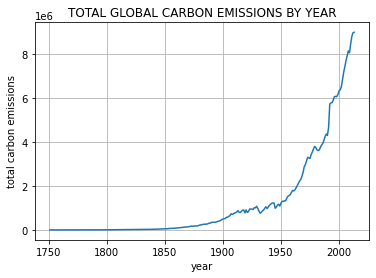

In [14]:
# plot of global carbon emissions 

carb_global_sum = df.groupby('year').sum()['total']

plt.plot(carb_global_sum)
plt.title('TOTAL GLOBAL CARBON EMISSIONS BY YEAR')
plt.xlabel('year')
plt.ylabel('total carbon emissions')
plt.grid()

# we see steep rise of global carbon emissions in late 20th and 21th centruy
# however, this might be the artifact of more countries measuring their carbon emissions in recent ages

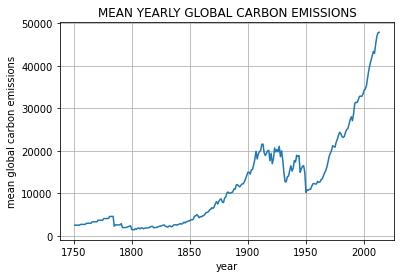

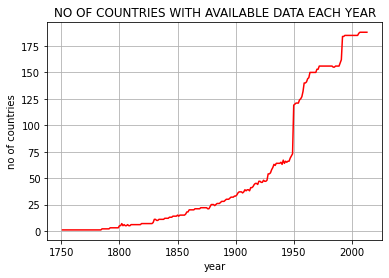

In [15]:
# so, again same graph, this time using MEAN instead SUM as a grouping clause in GROUP BY statement

carb_global_mean = df.groupby('year').mean()['total']

plt.figure()
plt.plot(carb_global_mean)
plt.title('MEAN YEARLY GLOBAL CARBON EMISSIONS')
plt.xlabel('year')
plt.ylabel('mean global carbon emissions')
plt.grid()

# here data is normalized by number of countries where carbon emissions are actually measured for each year
# again, this data could be artefact of no of countries which provide measures each year
# for example, drop around 1950 could be result of beginning of records 
# from more smaller countries, with low emissions
# so, number of countries in each year is also plotted

countries_per_year_cnt = []

for i in df['year'].unique():
    x = df[df['year']==i]
    countries_per_year_cnt.append(len(x))

plt.figure()
plt.plot(df['year'].unique(), countries_per_year_cnt, color = 'red')
plt.title('NO OF COUNTRIES WITH AVAILABLE DATA EACH YEAR')
plt.xlabel('year')
plt.ylabel('no of countries')
plt.grid()

plt.show()

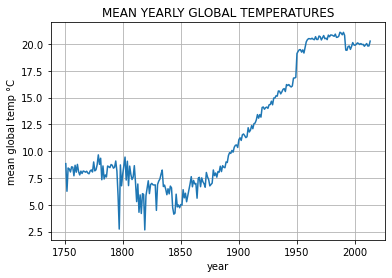

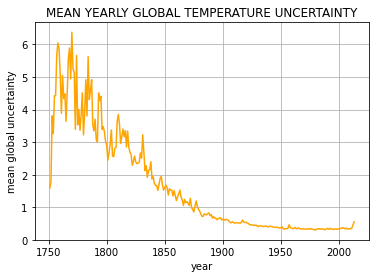

In [72]:
# mean world temperature by year

temp_global = df.groupby('year').mean()['avg_temp']

plt.figure()
plt.plot(temp_global)
plt.title('MEAN YEARLY GLOBAL TEMPERATURES')
plt.xlabel('year')
plt.ylabel('mean global temp °C')
plt.grid()

# GLOBAL WARMING !? or just more recordings from small tropical countries in recent age
# and records from developed countries in Northen Hempisphere in earlier years?
# also, there are a lot of small countries in tropical areas and only few bigger ones in colder areas
# average weights them equally

# also, plotting temperature uncertainity

temp_global_unc = df.groupby('year').mean()['avg_temp_uncertainty']

plt.figure()
plt.plot(df['year'].unique(), temp_global_unc, color = 'orange')
plt.title('MEAN YEARLY GLOBAL TEMPERATURE UNCERTAINTY')
plt.xlabel('year')
plt.ylabel('mean global uncertainty')
plt.grid()

In [16]:
# seing how global temperatures from temp_global table look like
# to confirm or discard above question
# however, we don't know from which measurements this data was derived

temp_global = pd.read_sql('SELECT * FROM temp_global', conn)
temp_global.head()

,temp_global.dt,temp_global.land_avg_temp,temp_global.land_avg_temp_uncertainty,temp_global.land_max_temp,temp_global.land_max_temp_uncertainty,temp_global.land_min_temp,temp_global.land_min_temp_uncertainty,temp_global.land_ocean_avg_temp,temp_global.land_ocean_avg_temp_uncertainty
0,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062
1,2000-01-01,2.950,0.091,8.349,0.103,-2.322,0.072,13.773,0.064
2,2000-02-01,4.184,0.093,9.863,0.096,-1.371,0.092,14.266,0.065
3,2000-03-01,6.219,0.120,12.205,0.133,0.376,0.082,14.846,0.069
4,2000-04-01,9.552,0.075,15.534,0.156,3.680,0.153,15.762,0.062


In [17]:
temp_global.shape

(3192, 9)

In [18]:
temp_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   temp_global.dt                               3192 non-null   object 
 1   temp_global.land_avg_temp                    3180 non-null   float64
 2   temp_global.land_avg_temp_uncertainty        3180 non-null   float64
 3   temp_global.land_max_temp                    1992 non-null   float64
 4   temp_global.land_max_temp_uncertainty        1992 non-null   float64
 5   temp_global.land_min_temp                    1992 non-null   float64
 6   temp_global.land_min_temp_uncertainty        1992 non-null   float64
 7   temp_global.land_ocean_avg_temp              1992 non-null   float64
 8   temp_global.land_ocean_avg_temp_uncertainty  3192 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [19]:
# keeping only date as index and land_avg_temp

ind = pd.to_datetime(temp_global['temp_global.dt'])
temp_global.index = ind
temp_global = temp_global['temp_global.land_avg_temp'].sort_index()

In [20]:
# resampling as year

temp_global = temp_global.resample('y').mean()

In [21]:
temp_global.head()

temp_global.dt
1750-12-31    8.719364
1751-12-31    7.976143
1752-12-31    5.779833
1753-12-31    8.388083
1754-12-31    8.469333
Freq: A-DEC, Name: temp_global.land_avg_temp, dtype: float64

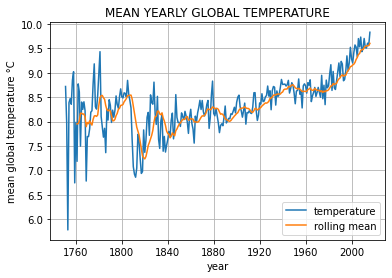

In [22]:
# its rolling mean of window 11

rmean = temp_global.rolling(11).mean()

plt.figure()
plt.plot(temp_global, label = 'temperature')
plt.plot(rmean, label = 'rolling mean')
plt.title('MEAN YEARLY GLOBAL TEMPERATURE')
plt.xlabel('year')
plt.ylabel('mean global temperature °C')
plt.legend()
plt.grid()

# now we see global warming, if we assume this data is correct

In [23]:
# we have seen that averaging data over countries to get global data makes us error prone
# so lets look at data on country level

# choosing some most interesting countries

countries = ['UNITED STATES', 'CHINA', 'INDIA', 'RUSSIA', 'BRAZIL', 'FRANCE', 
             'GERMANY', 'UNITED KINGDOM', 'AUSTRALIA']

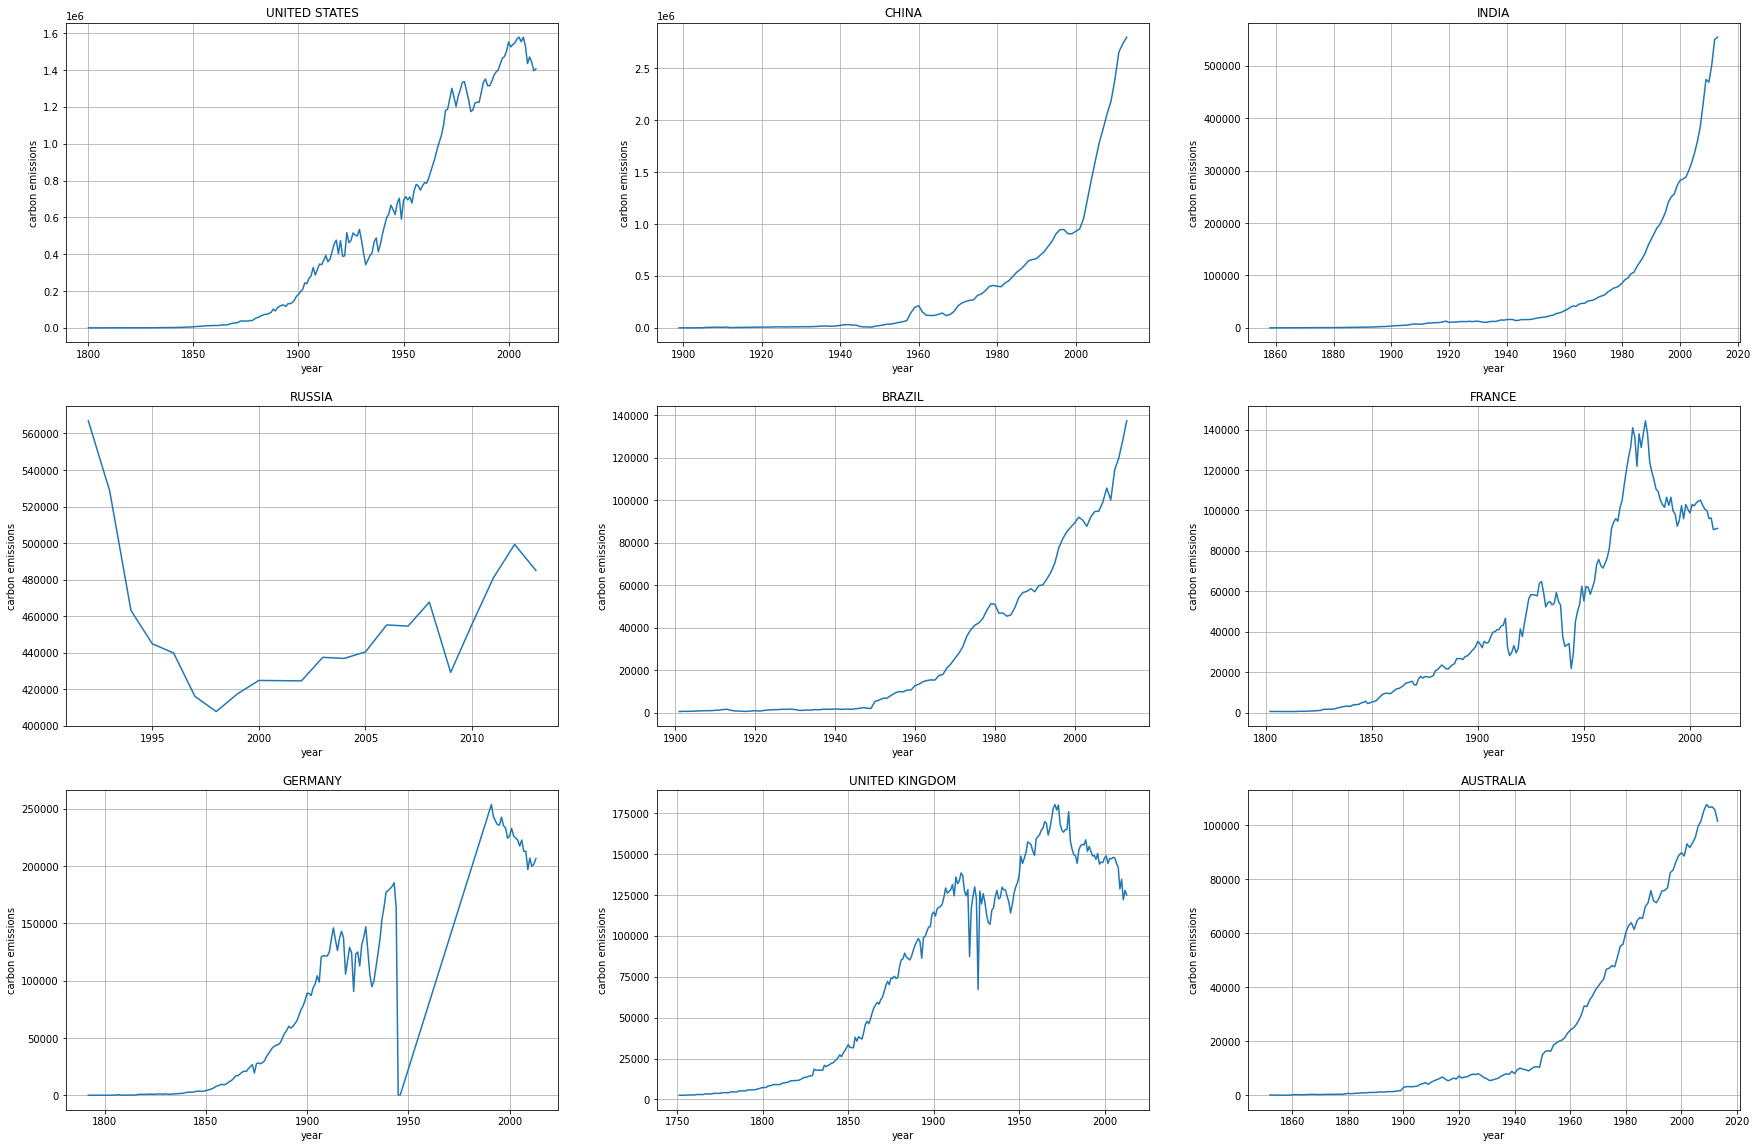

In [24]:
# carbon emissions

plt.figure(figsize = (30,20))

for i in range(len(countries)):
    
    x = df[df['country']==countries[i]]
    x.index = x['year']
    x = x.sort_index()
    x = x['total']

    plt.subplot(3,3,i+1)
    plt.plot(x)
    plt.title(countries[i])
    plt.xlabel('year')
    plt.ylabel('carbon emissions')
    plt.grid()

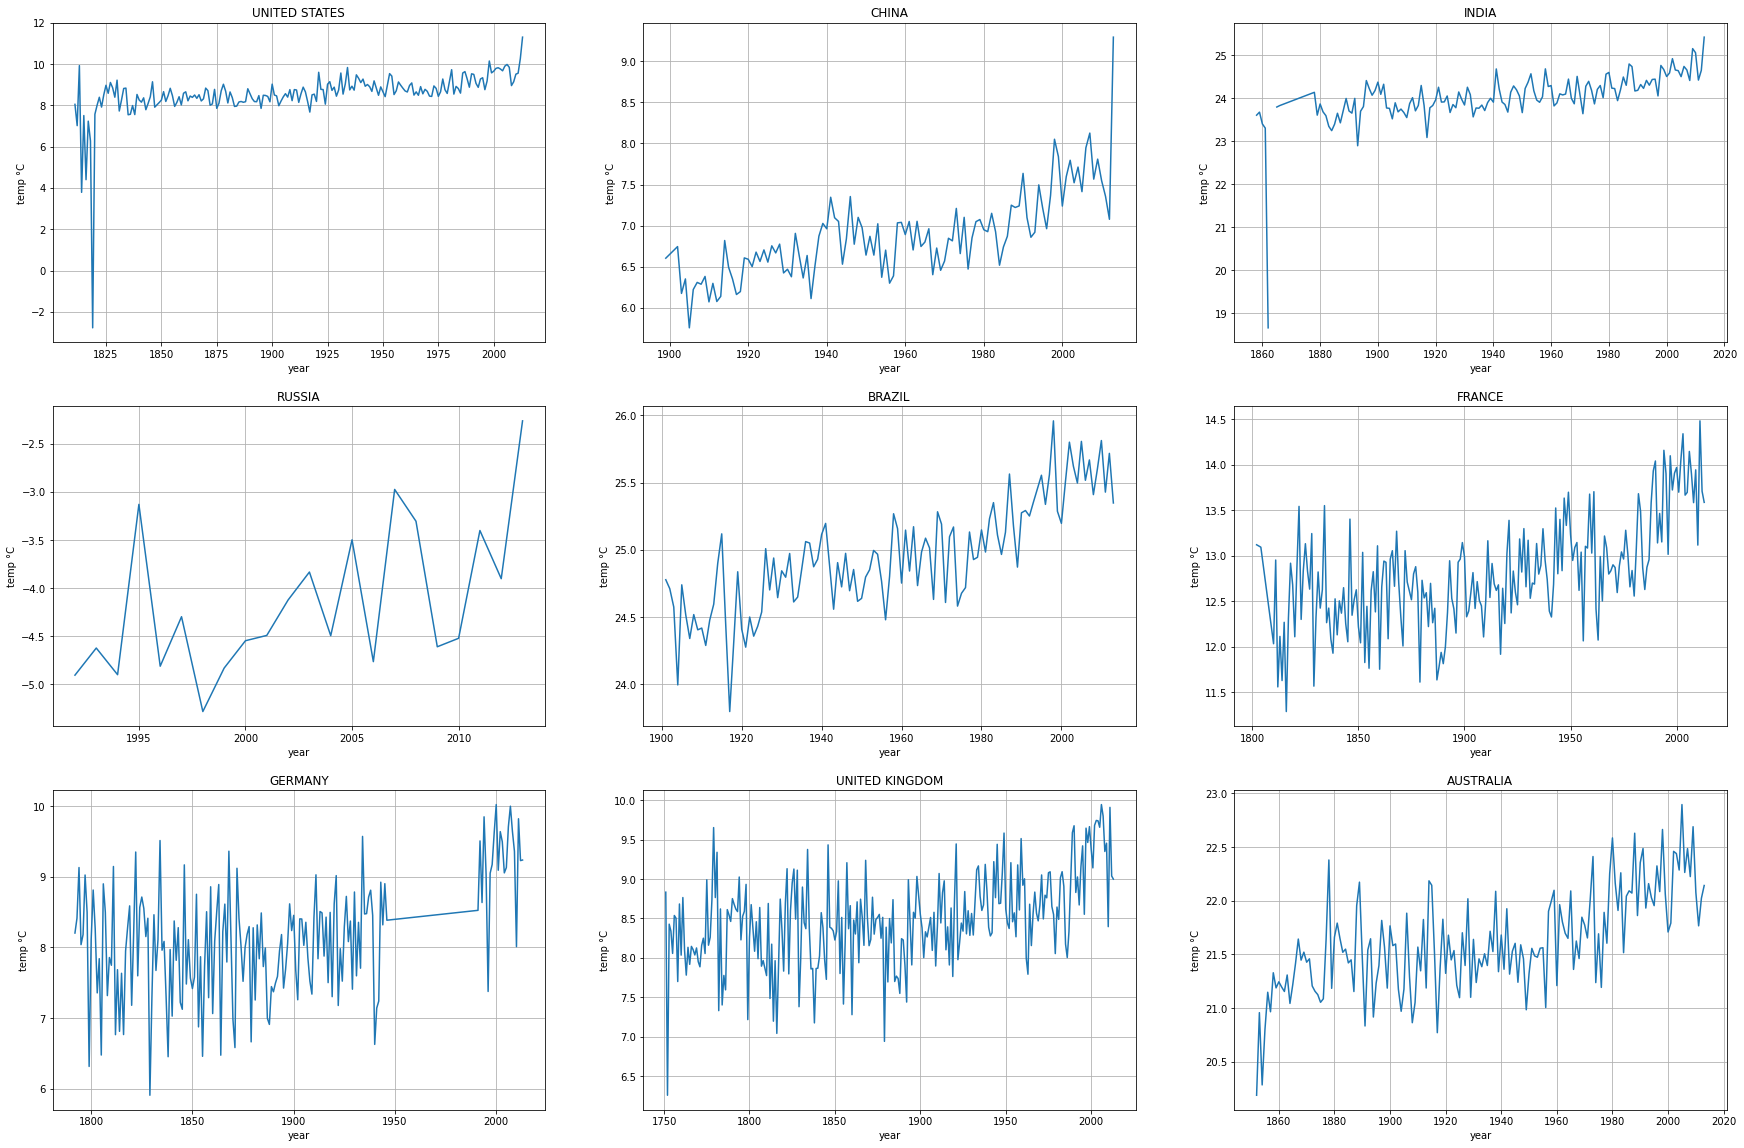

In [25]:
# temperatures

plt.figure(figsize = (30,20))

for i in range(len(countries)):
    
    x = df[df['country']==countries[i]]
    x.index = x['year']
    x = x.sort_index()
    x = x['avg_temp']

    plt.subplot(3,3,i+1)
    plt.plot(x)
    plt.title(countries[i])
    plt.xlabel('year')
    plt.ylabel('temp °C')
    plt.grid()

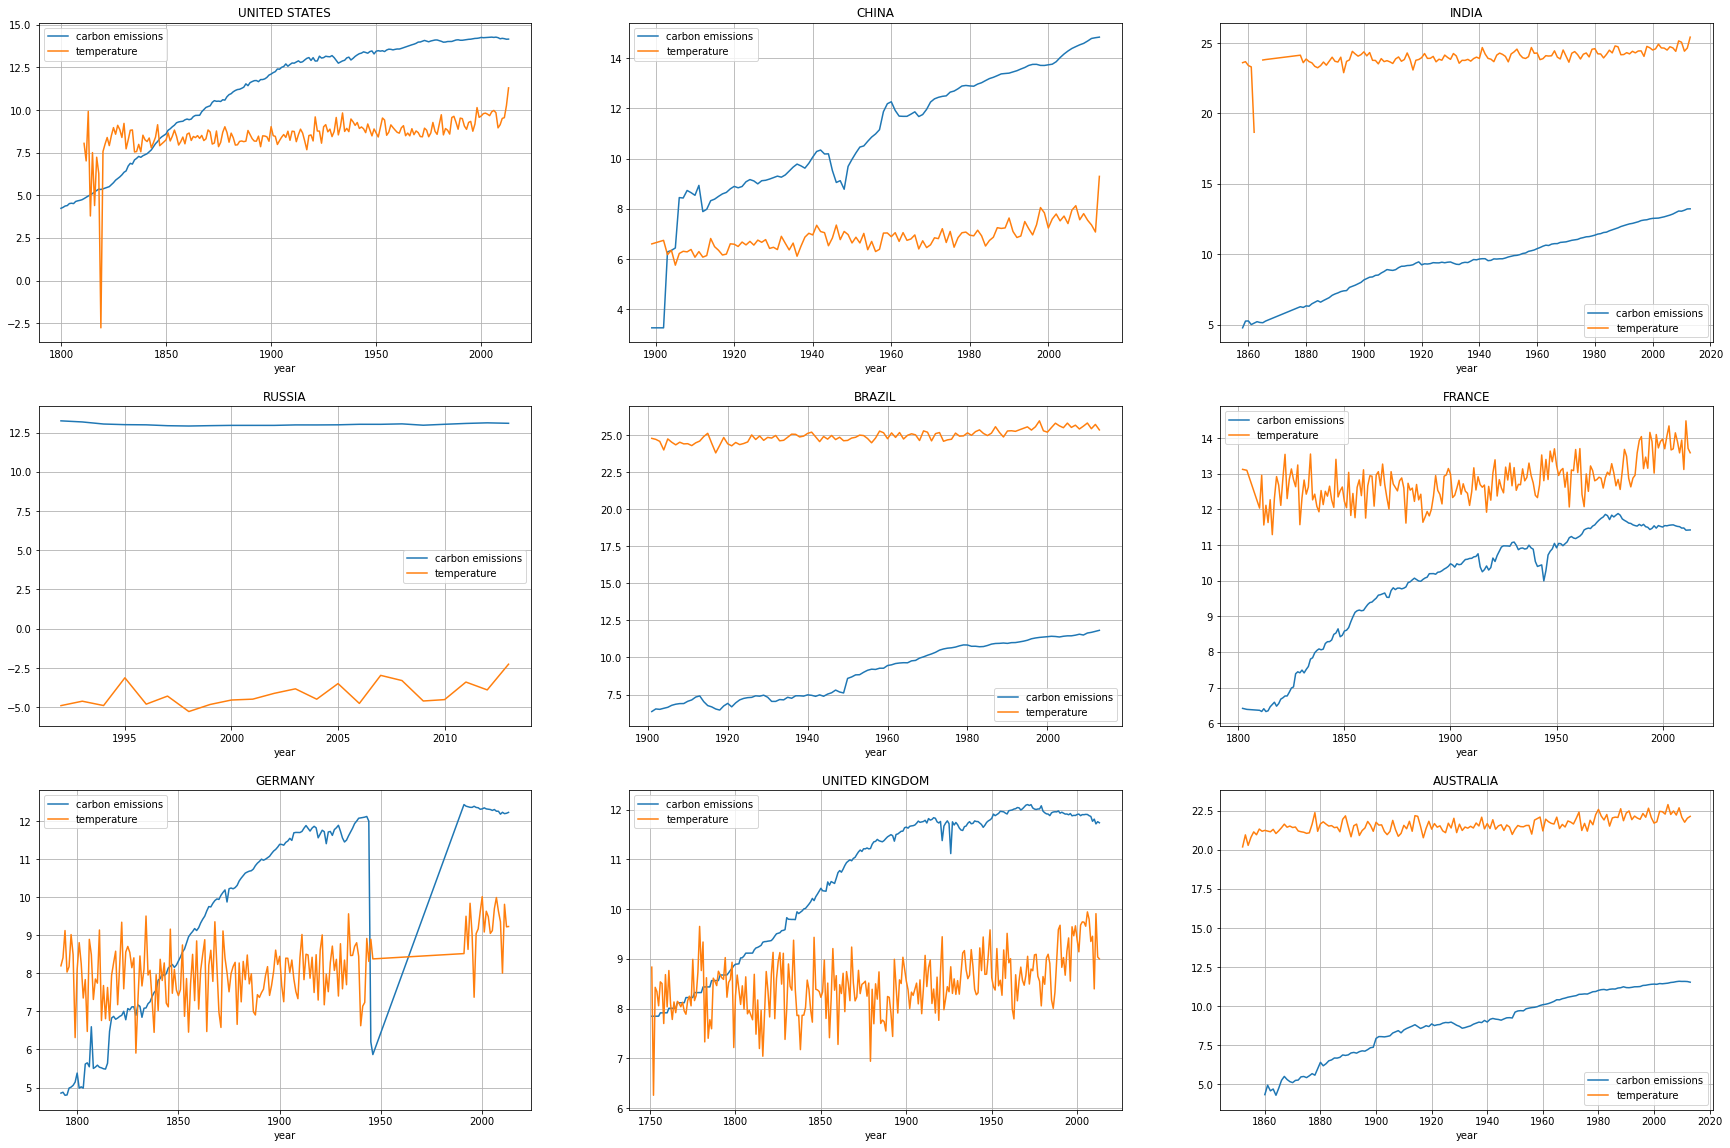

In [27]:
# log carbon emissions and temperature

plt.figure(figsize = (30,20))

for i in range(len(countries)):
    
    x = df[df['country']==countries[i]]
    x.index = x['year']
    x = x.sort_index()
    #carbon
    x1 = np.log(x['total']+0.01)
    #temp
    x2 = x['avg_temp']

    plt.subplot(3,3,i+1)
    plt.plot(x1, label = 'carbon emissions')
    plt.plot(x2, label = 'temperature')
    plt.title(countries[i])
    plt.xlabel('year')
    plt.legend()
    plt.grid()
    
    
# we see  that we generally have some weak relation between carbon emissions and global warming:
# both temperatures and carbon emissions tend to grow with time
# however, carbon emissions growth is vast, and temperatures grow slowly
# also, they don't have equal time distribution: change in carbon emissions does not lead to immediate temperature
# growth or vice versa
# We can draw some conclusions about correlation of these 2 variables
# but we also have to keep in mind that correlation does not mean causation

# also we se there is some missing and invalid data

# Time series modeling

We believe predicting carbon emissions on yearly level is relatively simple, and yet ungrateful task. As we can see from carbon time plots, these are mostly trend based singals, with tendency to grow (and some of them drop in recent years, moslty in developed western countries which invest more in renewable energy). They have no seasonality. In that sense, possibly best method here is Holt-Winters, without the seasonality component. Still this model would probably be able to give only rough and imprecise estimates (as would others), since carbon emissions can be impacted by outer factors such as state of economy etc. Recent COVID-19 pandemic also resulted in significant worldwide drop of emissions: another indicator of ungratefulness of this problem.

Temperatures, on the other hand, should have seasonal component if observed monthly or daily. However, weather conditions are very volatile in general, and probably also not that dependent on previous states when viewed on aggregated levels (2 months or weeks could have very different mean temperature, even days can differ significantly). So, modeling temperature based only on its past values, without other meteorological data is probably unfeasible. Still, we will try to do it with ARIMA for the sake of demonstration.

In [99]:
# Holt-Winters exponential smoothing
# carbon emissions in USA

from statsmodels.tsa.api import ExponentialSmoothing

carb_usa = df[df['country'] == 'UNITED STATES']
carb_usa.index = carb_usa['year']
carb_usa = carb_usa['total']

# train test split - train dataset is 85% of time series

print(len(carb_usa), 0.85*len(carb_usa))

214 181.9


In [100]:
usa_train = carb_usa[:182]
usa_test = carb_usa[182:]

In [101]:
exs = ExponentialSmoothing(usa_train.values, trend='add', damped=True, seasonal=None)

In [102]:
exs.fit()

In [103]:
usa_pred = exs.predict(exs.params, 183, 182+32)

In [104]:
usa_pred.shape

(32,)

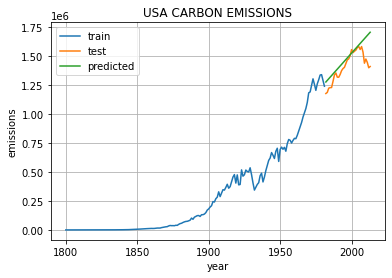

In [106]:
usa_pred = pd.Series(usa_pred, index=usa_test.index)

plt.plot(usa_train, label = 'train')
plt.plot(usa_test, label = 'test')
plt.plot(usa_pred, label = 'predicted')
plt.title('USA CARBON EMISSIONS')
plt.xlabel('year')
plt.ylabel('emissions')
plt.legend()
plt.grid()

Our predictions work just fine. In recent years there is drop in emissions, but it can't be inferred from available data. Model fitted without train test split would probably learn something from this drop and predict decreasing trend. Or maybe, predictions would continue increasing, but at much lower rate. So lets try it.

In [109]:
exs = ExponentialSmoothing(carb_usa.values, trend='add', damped=True, seasonal=None)
exs.fit()

In [118]:
# prediction for next 15 years - 2014 to 2029

usa_pred = exs.predict(exs.params, 215, 229)

In [119]:
usa_pred.shape

(15,)

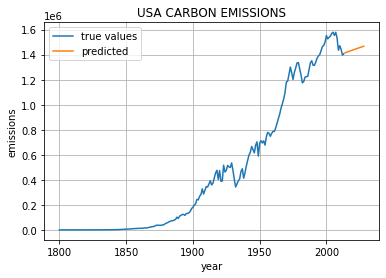

In [124]:
usa_pred = pd.Series(usa_pred, index=np.arange(2014,2029))

plt.plot(carb_usa, label = 'true values')
plt.plot(usa_pred, label = 'predicted')
plt.title('USA CARBON EMISSIONS')
plt.xlabel('year')
plt.ylabel('emissions')
plt.legend()
plt.grid()

# it seems that predictions continue to grow, just at much smaller rate

### ARIMA on monthly temperatures

In [138]:
# ARIMA on monthly temperatures for Zagreb

query = '''SELECT * FROM temp_city WHERE city = 'Zagreb' '''

zagreb = pd.read_sql(query, conn)

In [139]:
zagreb.head()

,temp_city.dt,temp_city.avg_temp,temp_city.avg_temp_uncertainty,temp_city.city,temp_city.country,temp_city.latitude,temp_city.longitude
0,1743-11-01,5.486,1.899,Zagreb,Croatia,45.81N,15.00E
1,1743-12-01,NaN,NaN,Zagreb,Croatia,45.81N,15.00E
2,1744-01-01,NaN,NaN,Zagreb,Croatia,45.81N,15.00E
3,1744-02-01,NaN,NaN,Zagreb,Croatia,45.81N,15.00E
4,1744-03-01,NaN,NaN,Zagreb,Croatia,45.81N,15.00E


In [140]:
zagreb.shape

(3239, 7)

In [141]:
zagreb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   temp_city.dt                    3239 non-null   object 
 1   temp_city.avg_temp              3166 non-null   float64
 2   temp_city.avg_temp_uncertainty  3166 non-null   float64
 3   temp_city.city                  3239 non-null   object 
 4   temp_city.country               3239 non-null   object 
 5   temp_city.latitude              3239 non-null   object 
 6   temp_city.longitude             3239 non-null   object 
dtypes: float64(2), object(5)
memory usage: 177.3+ KB


In [142]:
zagreb.index = pd.to_datetime(zagreb['temp_city.dt'].values)
zagreb = zagreb['temp_city.avg_temp']

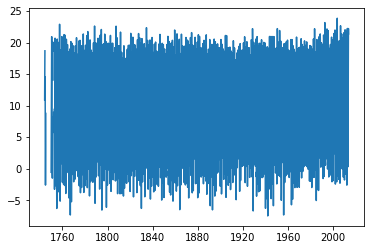

In [144]:
# most missing values seem to be in 1700s

plt.plot(zagreb)

In [150]:
# we can drop all data before 1800 to see if there are any missing values

zagreb = zagreb[zagreb.index > '1800-01-01']

# also, last value is missing

zagreb = zagreb[:-1]

In [151]:
zagreb.isna().sum()

0

In [153]:
# time series seems stationary 
# stationarity test to confirm it

adf = pmdarima.arima.ADFTest()

adf.should_diff(zagreb)

# it seems ts is really stationary

(0.01, False)

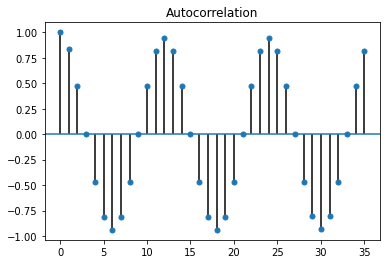

In [160]:
# acf and pacf plots 

pmdarima.utils.plot_acf(zagreb)

# on the acf, we can see that months tend to be somewhat correlated with month before
# also, we see strong seasonality patterns - negative correlation with month 6 months before and positive with same month last year

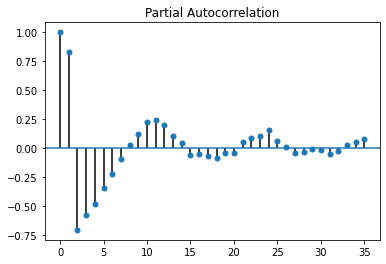

In [162]:
# pacf shows correlation with preceeding month
# again some seasonal patterns
# however, it shows unexpectedly strong negative correlations with preceeding few months

pmdarima.utils.plot_pacf(zagreb)

In [221]:
# based on analysis of acf and pacf, i will choose following model:
# ARIMA((1,0,0),(4,0,4,6))
# this model uses one AR and no MA
# also, it uses 4 seasonal ARs and MAs, where seasonality is set to 6 months
# i.e. it uses values from previous month which was 6 months before and same month from previous year
# for 2 preceeding years
# this model does not use differencing since time series is already stationary

arima = pmdarima.arima.ARIMA(order=(1,0,0), seasonal_order=(4,0,4,6), maxiter=300)

In [207]:
# getting length of data

print(len(zagreb), 0.85*len(zagreb))

2563 2178.5499999999997


In [208]:
# train test split

train = zagreb[:2179]
test = zagreb[2179:]

In [223]:
arima.fit(train)

/home/cloudera/.local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ARIMA(maxiter=300, order=(1, 0, 0), seasonal_order=(4, 0, 4, 6))

In [224]:
arima.summary()

# Ljung Box test is ok - no autocorrelated lags
# JArque-Bera test results indicate some problems with normal distribution of residuals
# however, if we look at diagnostic plots below we see that errors distributuon is close to normal
# except for having heavier tail on left side
# J-B test result could be artifact of big sample size
# also there are no significant autocorrelations at 30 lags
# almost all used coefficients are statistically significant
# so generally this ARIMA is feasible

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                            y   No. Observations:                 2179
Model:             SARIMAX(1, 0, 0)x(4, 0, [1, 2, 3, 4], 6)   Log Likelihood               -4162.891
Date:                                      Thu, 11 Jun 2020   AIC                           8347.782
Time:                                              19:35:24   BIC                           8410.335
Sample:                                                   0   HQIC                          8370.651
                                                     - 2179                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0318      0.033      0.974      0.330      -0.032       0.096
ar.L1          0.2040      0.020     10.209      0.000       0.165       0.243
ar.S.L6        0.9677      0.019     50.412      0.000       0.930       1.005
ar.S.L12       0.0196      0.019      1.019      0.308      -0.018       0.057
ar.S.L18      -0.9699      0.019    -51.190      0.000      -1.007      -0.933
ar.S.L24       0.9783      0.019     50.555      0.000       0.940       1.016
ma.S.L6       -0.9728      0.019    -51.661      0.000      -1.010      -0.936
ma.S.L12       0.0028      0.019      0.151      0.880      -0.034       0.040
ma.S.L18       0.9646      0.019     50.583      0.000       0.927       1.002
ma.S.L24      -0.9679      0.019    -50.843      0.000      -1.005      -0.931
sigma2         2.6081      0.069     37.628      0.000       2.472       2.744
===================================================================================
Ljung-Box (Q):                       29.41   Jarque-Bera (JB):                57.65
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.19
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

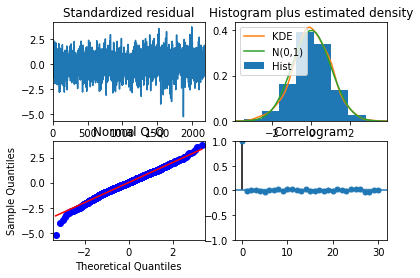

In [225]:
arima.plot_diagnostics(lags=30)
plt.show()

In [226]:
pred, ci = arima.predict(len(test), return_conf_int=True)

In [227]:
pred.shape, test.shape, ci.shape

((384,), (384,), (384, 2))

In [228]:
pred = pd.Series(pred, index = test.index)

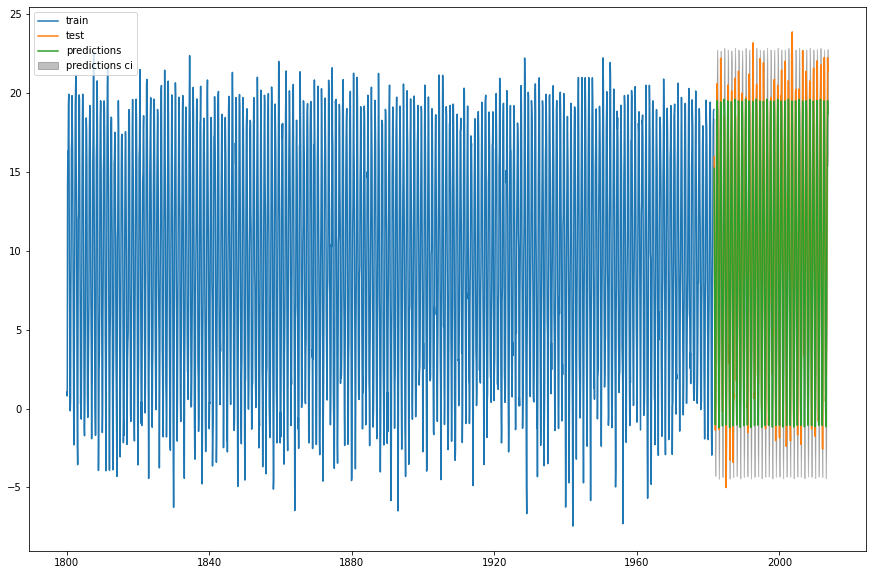

In [229]:
plt.figure(figsize=(15,10))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(pred, label = 'predictions')
plt.fill_between(x = pred.index, y1 = ci[:,0], y2 = ci[:,1], alpha=0.25, color='black', label = 'predictions ci')
plt.legend(loc = 'upper left')

# we see predictions look feasible
# however, temperature is very stohastic variable, and predicting it only from itself is ungrateful task
# we see that real data sometimes goes out of range of confidence intervals
# this could be effect of global warming - we see that we get more highs in recent period
# which coincides with testing and predicted datapoints, and model is learned on past data with less high temperature spikes
# model seems very stable
# however, our model does not bring much that practical value - we could deduce feasible range of temperature for each month
# without all this maths and modeling

In [230]:
# model RMSE

from sklearn.metrics import mean_squared_error as mse

np.sqrt(mse(test, pred))

1.8990030994213825

In [ ]:
# lets try auto ARIMA to see if we can find better model
# although above model perforoms good

In [245]:
auto_arima = pmdarima.arima.AutoARIMA(start_p=0, max_p=3, start_q=0, max_q=3, start_P=1, start_Q=1, max_P=6, max_Q=6, 
                                      max_order=20, n_jobs=-1, maxiter=300, m=6)

In [246]:
auto_arima.fit(train)

/home/cloudera/.local/lib/python3.6/site-packages/pmdarima/arima/auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


AutoARIMA(m=6, max_P=6, max_Q=6, max_order=20, max_p=3, max_q=3, maxiter=300,
          n_jobs=-1, start_p=0, start_q=0)

In [247]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2179
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 6)   Log Likelihood               -4192.843
Date:                             Thu, 11 Jun 2020   AIC                           8395.687
Time:                                     19:57:01   BIC                           8424.120
Sample:                                          0   HQIC                          8406.081
                                            - 2179                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.7127      0.380     38.755      0.000      13.969      15.457
ar.L1          0.2132      0.020     10.743      0.000       0.174       0.252
ar.S.L6       -1.0000   3.83e-06  -2.61e+05      0.000      -1.000      -1.000
ma.S.L6        0.9925      0.005    211.581      0.000       0.983       1.002
sigma2         2.6964      0.073     37.113      0.000       2.554       2.839
===================================================================================
Ljung-Box (Q):                       67.71   Jarque-Bera (JB):                43.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [248]:
pred, ci = auto_arima.predict(len(test), return_conf_int=True)

In [249]:
#RMSE

np.sqrt(mse(test, pred))

1.9811229350750237

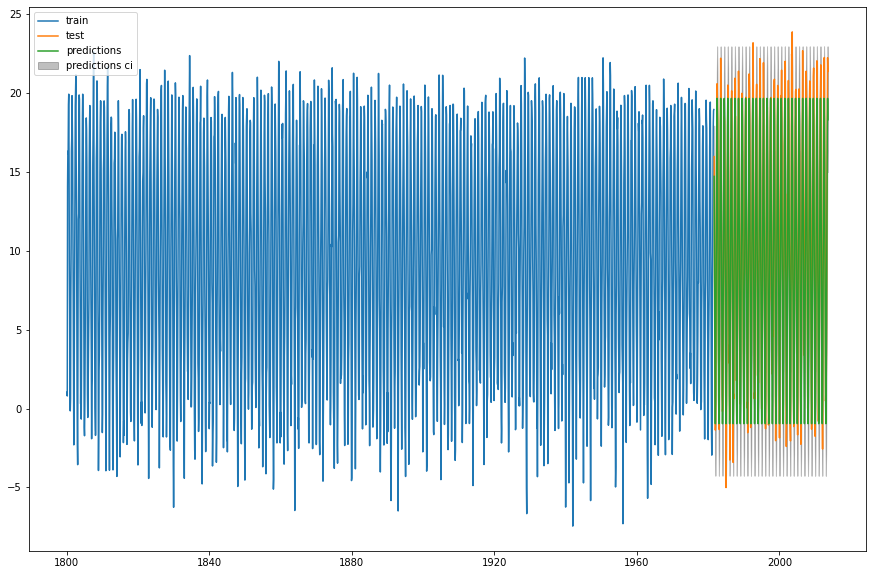

In [250]:
pred = pd.Series(pred, index=test.index)

plt.figure(figsize=(15,10))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.plot(pred, label = 'predictions')
plt.fill_between(x = pred.index, y1 = ci[:,0], y2 = ci[:,1], alpha=0.25, color='black', label = 'predictions ci')
plt.legend(loc = 'upper left')

Results of both models look similar. However, our created model has somewhat better AIC and BIC, although it uses more parameters than automatic model. Also, it has a bit better RMSE. So we would keep that model.